[https://medium.com/@ab.jannatpour/advanced-pairs-trading-kalman-filters-b171144ce6d5](https://)

In [122]:
import sys
sys.path.append('../../')

In [123]:
from util.load_data import *
from config.constants import *
import statsmodels.api as sm
import quantstats as qs

In [124]:
XAUUSD = load_data()

In [125]:
data_1 = XAUUSD['D1']

In [126]:
data_2 = pd.read_csv(
    PATH_DATA + '/USDJPY/USDJPY_D1 - USDJPY_D1' + '.csv', index_col='Time', parse_dates=True)

In [127]:
data_1 = data_1.reindex(data_2.index, method='ffill')  # fill forward

In [128]:
# Define the system model for the spread
A = 1
Q = 0.1

# Define the measurement model for the spread
H = 1
R = 0.1

In [129]:
mu = 0
sigma = 0.1

In [130]:
x = 0
P = 1

In [131]:
data_1

,Open,High,Low,Close,Volume
Time,,,,,
2007-02-12,666.520,666.898,659.061,660.524,1329
2007-02-13,660.511,668.870,659.846,663.033,1353
2007-02-14,663.468,671.708,663.013,668.469,1333
2007-02-15,668.441,670.400,661.906,667.930,1332
2007-02-16,668.023,669.348,662.058,668.094,1187
...,...,...,...,...,...
2023-03-06,1852.255,1858.168,1845.015,1846.255,1380
2023-03-07,1846.225,1851.555,1812.655,1813.865,1380
2023-03-08,1813.855,1824.185,1809.248,1815.175,1379


In [132]:
data_2

,Open,High,Low,Close,Volume
Time,,,,,
2007-02-12,121.900,121.953,121.730,121.764,64849
2007-02-13,121.760,121.766,121.090,121.263,618320
2007-02-14,121.272,121.347,120.226,120.286,616539
2007-02-15,120.282,120.359,119.147,119.376,617115
2007-02-16,119.370,119.550,118.984,119.392,586044
...,...,...,...,...,...
2023-03-06,136.016,136.190,135.364,135.995,506836
2023-03-07,135.995,137.438,135.537,137.387,595894
2023-03-08,137.392,137.910,136.477,137.223,528313


In [133]:
model = sm.OLS(data_1['Close'], data_2['Close'])
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Close   R-squared (uncentered):                   0.922
Model:                            OLS   Adj. R-squared (uncentered):              0.922
Method:                 Least Squares   F-statistic:                          5.972e+04
Date:                Mon, 05 Feb 2024   Prob (F-statistic):                        0.00
Time:                        22:16:22   Log-Likelihood:                         -37037.
No. Observations:                5021   AIC:                                  7.408e+04
Df Residuals:                    5020   BIC:                                  7.408e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Close         12.5893      0.052    244.371      0.000      12.488      12.690
==============================================================================
Omnibus:                       64.002   Durbin-Watson:                   0.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.023
Skew:                          -0.016   Prob(JB):                     3.36e-09
Kurtosis:                       2.569   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [134]:
import numpy as np
from pykalman import KalmanFilter
import pandas as pd

# defining a mean-reverting system model

# Assuming you have appropriate values for A, H, x, P, Q, and R
# ...
stock1 = data_1
stock2 = data_2
signal = data_1

# calculate the spread
signal['spread'] = stock1['Close'] - stock2['Close']

signal['stock1_signal'] = 0
signal['stock2_signal'] = 0


# Create the Kalman filter object

# Signal generation logic

sigma = np.std(signal['spread'])

# Define the long-term mean
mu = np.mean(signal['spread'])

# Define the transition matrix
A = np.array([1])

# Define the transition covariance
Q = np.array([0.1])

# Define the measurement matrix
H = np.array([1])

# Define the measurement covariance
R = np.array([0.1])

# Define the initial state
x_init = np.array([mu])
P_init = np.array([1])


# Initialize the Kalman filter
kf = KalmanFilter(transition_matrices=A, observation_matrices=H,
                  transition_covariance=Q, observation_covariance=R,
                  initial_state_mean=x_init, initial_state_covariance=P_init)


# Loop over time steps
for i in range(len(signal['spread'])):
    # Prediction
    x_pred, P_pred = kf.filter_update(
        filtered_state_mean=x, filtered_state_covariance=P)

    # Measurement
    z = signal['spread'][i]

    # Update
    x, P = kf.filter_update(filtered_state_mean=x_pred,
                            filtered_state_covariance=P_pred, observation=z)

    (filtered_state_means, filtered_state_covariances) = kf.filter(signal['spread'][i])

   # Extract the final estimate of the spread
    estimated_spread = filtered_state_means[-1]
    # print(estimated_spread)

    # Extract the final estimate of the spread uncertainty
    estimated_spread_uncertainty = filtered_state_covariances[-1]
    # print(estimated_spread_uncertainty)

    # Signal generation logic


#    estimated_spread_uncertainty > sigma

    if estimated_spread > mu:
        signal.loc[signal.index[i], 'stock1_signal'] = 1
        signal.loc[signal.index[i], 'stock2_signal'] = -1
    elif estimated_spread < mu:
        signal.loc[signal.index[i], 'stock1_signal'] = -1
        signal.loc[signal.index[i], 'stock2_signal'] = 1
    else:
        signal.loc[signal.index[i], ['stock1_signal', 'stock2_signal']] = 0

In [135]:
# import numpy as np
# from pykalman import KalmanFilter
# import pandas as pd

# # defining a mean-reverting system model

# # Assuming you have appropriate values for A, H, x, P, Q, and R
# # ...
# stock1 = data_1
# stock2 = data_2

# # calculate the spread
# spread = stock1['Close'] - stock2['Close']

# stock = spread.to_frame()
# # Create the Kalman filter object


# # Create a DataFrame to store signals
# signals = pd.DataFrame(index=spread.index, columns=[
#                        'stock1_signal', 'stock2_signal'])


# # Signal generation logic

# sigma = np.std(spread)

# # Define the long-term mean
# mu = np.mean(spread)

# # Define the transition matrix
# A = np.array([1])

# # Define the transition covariance
# Q = np.array([0.1])

# # Define the measurement matrix
# H = np.array([1])

# # Define the measurement covariance
# R = np.array([0.1])

# # Define the initial state
# x_init = np.array([mu])
# P_init = np.array([1])


# # Initialize the Kalman filter
# kf = KalmanFilter(transition_matrices=A, observation_matrices=H,
#                   transition_covariance=Q, observation_covariance=R,
#                   initial_state_mean=x_init, initial_state_covariance=P_init)


# # Loop over time steps
# for i in range(len(spread)):
#     # Prediction
#     x_pred, P_pred = kf.filter_update(
#         filtered_state_mean=x, filtered_state_covariance=P)

#     # Measurement
#     z = spread[i]

#     # Update
#     x, P = kf.filter_update(filtered_state_mean=x_pred,
#                             filtered_state_covariance=P_pred, observation=z)

#     (filtered_state_means, filtered_state_covariances) = kf.filter(spread[i])

#    # Extract the final estimate of the spread
#     estimated_spread = filtered_state_means[-1]
#     # print(estimated_spread)

#     # Extract the final estimate of the spread uncertainty
#     estimated_spread_uncertainty = filtered_state_covariances[-1]
#     # print(estimated_spread_uncertainty)

#     # Signal generation logic


# #    estimated_spread_uncertainty > sigma

#     if estimated_spread > mu:
#         signals.loc[spread.index[i], 'stock1_signal'] = 1
#         signals.loc[spread.index[i], 'stock2_signal'] = -1
#     elif estimated_spread < mu:
#         signals.loc[spread.index[i], 'stock1_signal'] = -1
#         signals.loc[spread.index[i], 'stock2_signal'] = 1
#     else:
#         signals.loc[spread.index[i], ['stock1_signal', 'stock2_signal']] = 0

In [136]:
signal.value_counts()

Open      High      Low       Close     Volume  spread    stock1_signal  stock2_signal
632.283   647.654   631.853   646.989   1396    530.213   -1              1               1
1493.066  1493.689  1487.180  1491.880  149     1411.168   1             -1               1
1495.096  1516.436  1493.225  1512.659  1420    1431.585   1             -1               1
1494.960  1515.806  1486.947  1511.875  1260    1430.203   1             -1               1
1494.803  1499.603  1487.515  1495.594  1419    1412.831   1             -1               1
                                                                                         ..
1224.189  1229.479  1218.101  1225.129  1380    1113.851  -1              1               1
1224.139  1224.659  1205.753  1209.381  1381    1088.735  -1              1               1
1224.078  1228.698  1219.838  1221.585  1373    1108.876  -1              1               1
1224.068  1227.312  1217.538  1222.679  1259    1111.673  -1              1          

In [137]:
signal

,Open,High,Low,Close,Volume,spread,stock1_signal,stock2_signal
Time,,,,,,,,
2007-02-12,666.520,666.898,659.061,660.524,1329,538.760,-1,1
2007-02-13,660.511,668.870,659.846,663.033,1353,541.770,-1,1
2007-02-14,663.468,671.708,663.013,668.469,1333,548.183,-1,1
2007-02-15,668.441,670.400,661.906,667.930,1332,548.554,-1,1
2007-02-16,668.023,669.348,662.058,668.094,1187,548.702,-1,1
...,...,...,...,...,...,...,...,...
2023-03-06,1852.255,1858.168,1845.015,1846.255,1380,1710.260,1,-1
2023-03-07,1846.225,1851.555,1812.655,1813.865,1380,1676.478,1,-1
2023-03-08,1813.855,1824.185,1809.248,1815.175,1379,1677.952,1,-1


In [138]:
signal['returns'] = signal['Close'].pct_change()

In [139]:
data_2['returns'] = data_2['Close'].pct_change()

In [140]:
signal['returns2'] = data_2['returns']

In [148]:
signal['returns_all'] = signal['returns'] * signal['stock1_signal'].shift(1) + \
    signal['returns2'] * signal['stock2_signal'].shift(1)

In [149]:
signal['returns'].dropna(inplace=True)

                           Strategy
-------------------------  ----------
Start Period               2007-02-13
End Period                 2023-03-10
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          -87.52%
CAGR﹪                     -8.55%

Sharpe                     -0.42
Prob. Sharpe Ratio         3.13%
Smart Sharpe               -0.41
Sortino                    -0.57
Smart Sortino              -0.56
Sortino/√2                 -0.4
Smart Sortino/√2           -0.4
Omega                      0.93

Max Drawdown               -90.39%
Longest DD Days            5735
Volatility (ann.)          20.2%
Calmar                     -0.09
Skew                       -0.28
Kurtosis                   5.32

Expected Daily %           -0.04%
Expected Monthly %         -1.07%
Expected Yearly %          -11.52%
Kelly Criterion            -3.81%
Risk of Ruin               0.0%
Daily Value-at-Risk        -2.13%
Expected Shortfall (cVaR)  -2.13%

Max Consecutive

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2007-06-28,2022-10-20,2023-03-10,5735,-90.393283,-89.428864
2,2007-02-14,2007-04-20,2007-05-16,92,-6.580597,-6.514567
3,2007-05-28,2007-06-06,2007-06-07,11,-2.841693,-2.580292
4,2007-06-17,2007-06-19,2007-06-19,3,-0.895801,-0.160189
5,2007-05-18,2007-05-20,2007-05-21,4,-0.748362,-0.728408


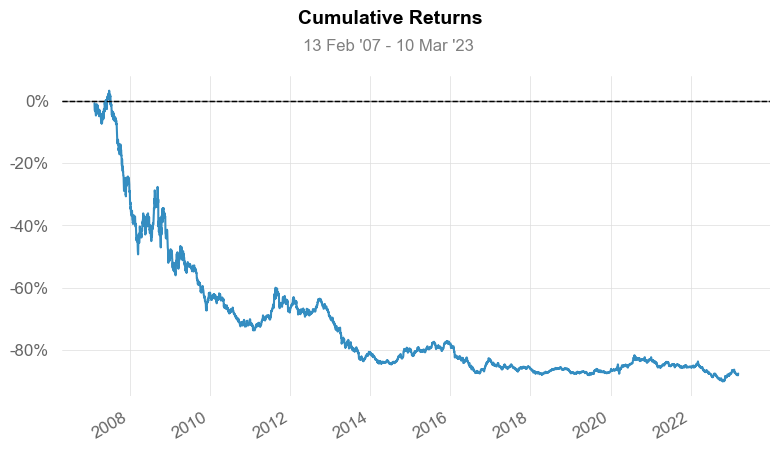

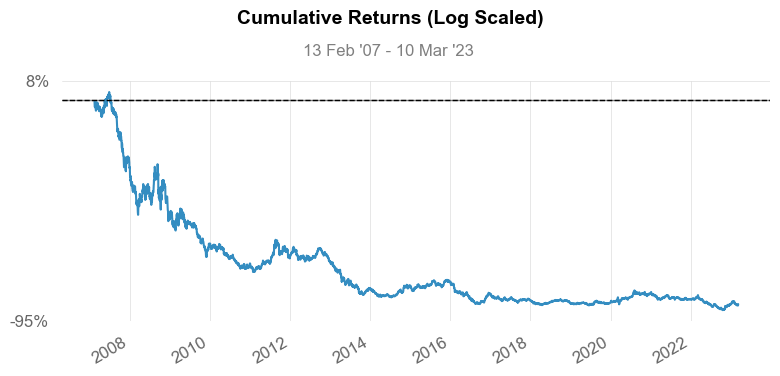

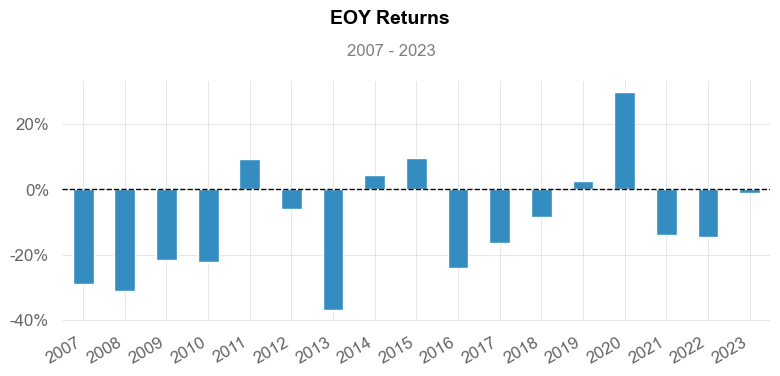

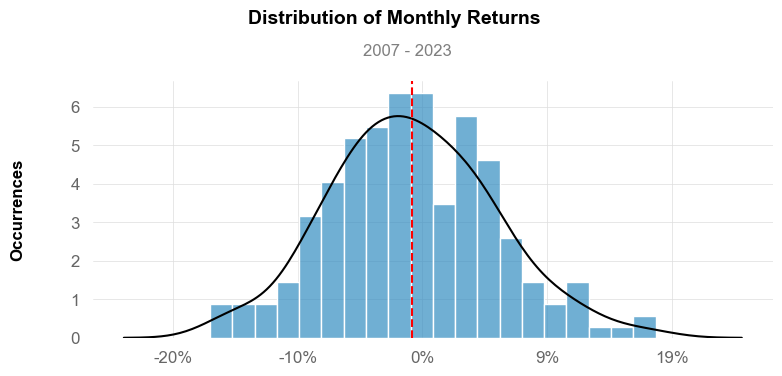

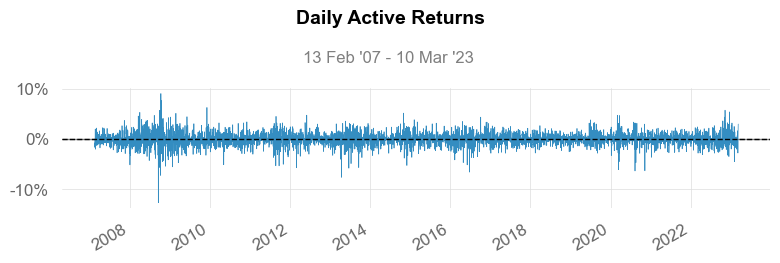

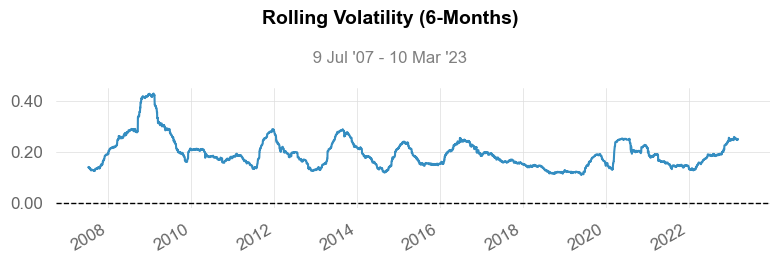

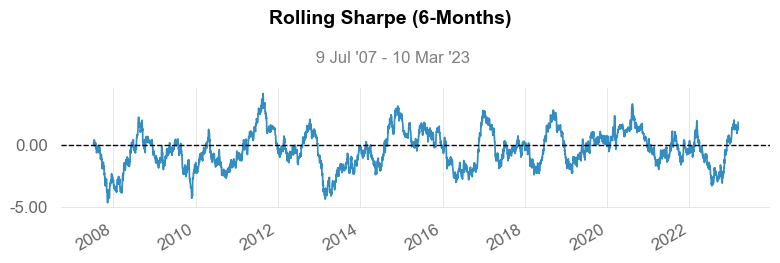

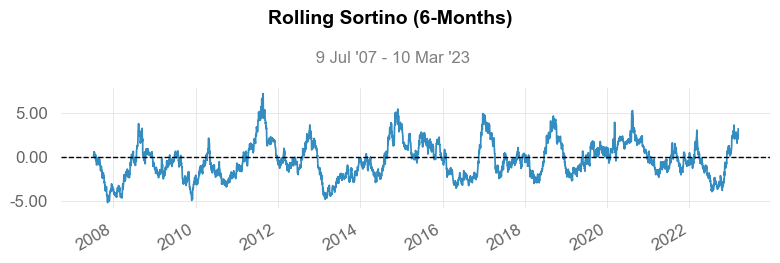

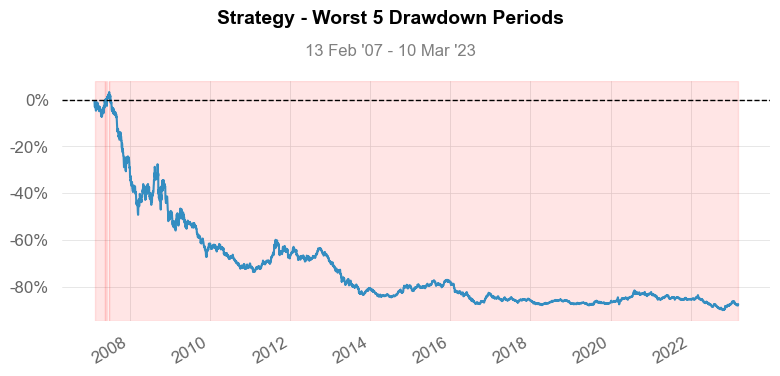

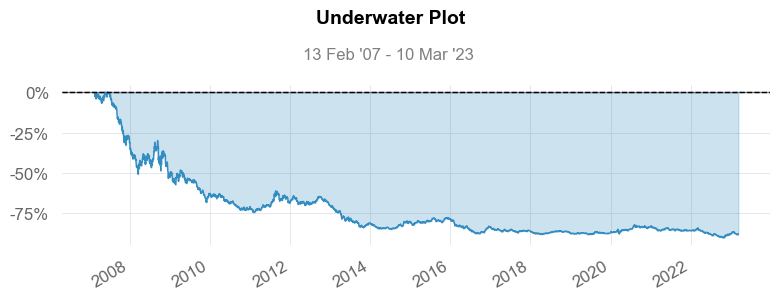

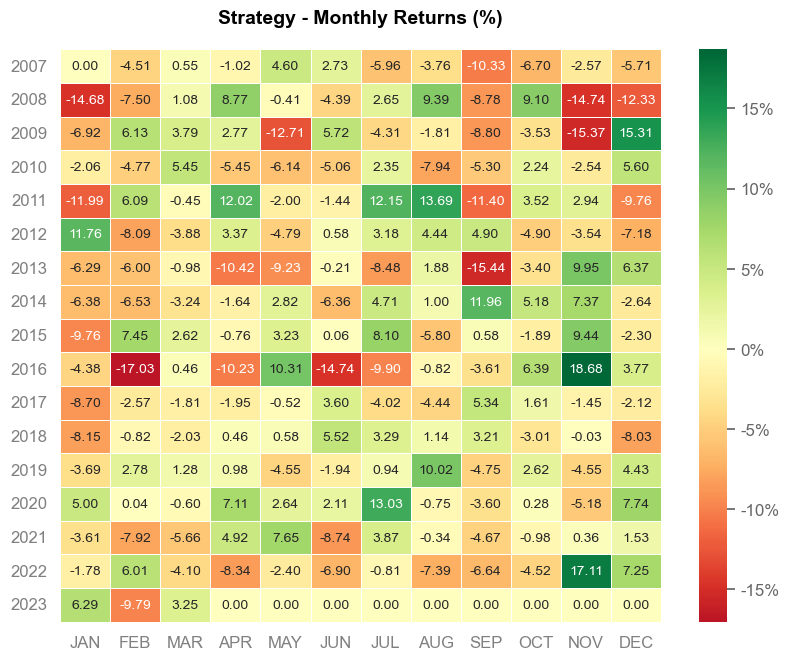

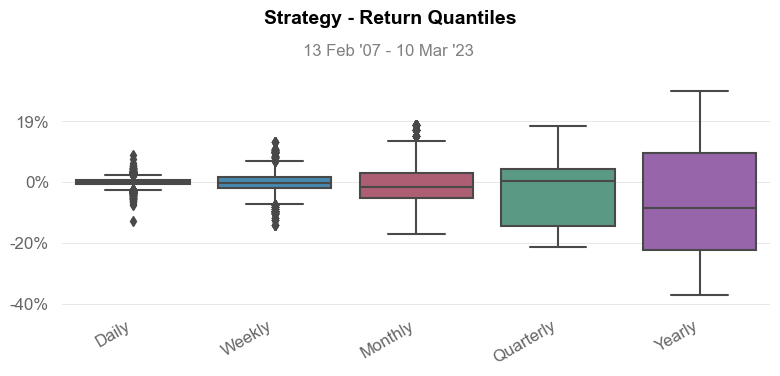

In [150]:
qs.reports.full(signal['returns_all'])